# From text to Knowledge Graph
In this notebook we will see how we can transform a simple sentence into a Knowledge Graph using simple steps.

## Natural Language Processing

In [1]:
import spacy
import spacy_dbpedia_spotlight
from spacy.matcher import Matcher 
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('dbpedia_spotlight')
doc = nlp("Joe Biden married Jill Tracy Jacobs, who was educated at the University of Delaware")

# Tokenization
print([token.text for token in doc], sep=' ')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

['Joe', 'Biden', 'married', 'Jill', 'Tracy', 'Jacobs', ',', 'who', 'was', 'educated', 'at', 'the', 'University', 'of', 'Delaware']


In [ ]:
# Lemmatisation
print([token.lemma_ for token in doc], sep=' ')

['Joe', 'Biden', 'marry', 'Jill', 'Tracy', 'Jacobs', ',', 'who', 'be', 'educate', 'at', 'the', 'University', 'of', 'Delaware']


In [ ]:
print([token.lemma_ for token in doc], sep=' ')

['DBPEDIA_ENT', 'DBPEDIA_ENT', '', 'DBPEDIA_ENT', 'DBPEDIA_ENT', '', '', '', '', '', '', '', '', '', 'DBPEDIA_ENT']


In [ ]:
# Part-of-speech Tagging
print([(token.lemma_, token.pos_) for token in doc], sep=' ')

[('Joe', 'PROPN'), ('Biden', 'PROPN'), ('marry', 'VERB'), ('Jill', 'PROPN'), ('Tracy', 'PROPN'), ('Jacobs', 'PROPN'), (',', 'PUNCT'), ('who', 'PRON'), ('be', 'AUX'), ('educate', 'VERB'), ('at', 'ADP'), ('the', 'DET'), ('University', 'PROPN'), ('of', 'ADP'), ('Delaware', 'PROPN')]


In [ ]:
# Dependency Parsing
print([(token.lemma_, token.dep_) for token in doc], sep=' ')

[('Joe', 'compound'), ('Biden', 'nsubj'), ('marry', 'ROOT'), ('Jill', 'compound'), ('Tracy', 'compound'), ('Jacobs', 'dobj'), (',', 'punct'), ('who', 'nsubjpass'), ('be', 'auxpass'), ('educate', 'relcl'), ('at', 'prep'), ('the', 'det'), ('University', 'pobj'), ('of', 'prep'), ('Delaware', 'pobj')]


In [ ]:
from spacy import displacy
displacy.render(doc, style="dep")

## Named Entity Recognition (NER)
Named Entity Recognition (NER) identifies mentions of named entities in a text, typically targetting mentions of people, organisations, locations, and potentially other types.

In [2]:
print([(ent.text, ent.label_) for ent in doc.ents], sep = ' ')

[('Joe Biden', 'DBPEDIA_ENT'), ('Jill Tracy', 'DBPEDIA_ENT'), ('Delaware', 'DBPEDIA_ENT')]


In [3]:
ents = [ent for ent in doc.ents]

In [4]:
ents_t = [ent.text for ent in doc.ents]

In [5]:
print("Before:", [token.text for token in doc])

with doc.retokenize() as retokenizer:
    for i in range(len(ents)):
        retokenizer.merge(doc.ents[i])
print("After:", [token.text for token in doc])

Before: ['Joe', 'Biden', 'married', 'Jill', 'Tracy', 'Jacobs', ',', 'who', 'was', 'educated', 'at', 'the', 'University', 'of', 'Delaware']
After: ['Joe Biden', 'married', 'Jill Tracy', 'Jacobs', ',', 'who', 'was', 'educated', 'at', 'the', 'University', 'of', 'Delaware']


## Named Entity Linking (NEL)

Named Entity Linking (NEL) is the task to task associate mentions of entities in a text with the existing nodes of a target knowledge graph.

In [6]:
print([ent.kb_id_ for ent in doc.ents])

['http://dbpedia.org/resource/Joe_Biden', 'http://dbpedia.org/resource/Jill_Tracy', 'http://dbpedia.org/resource/Delaware']


## Relation Extraction (RE)

Relation Extraction (RE) is the task of detecting and classifying relationships between entities extracted from text.

In [9]:
# we define some patterns to look for in the sentences

def get_relation(sent):
  aux = []
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP' : 'ROOT'}],[{'DEP' : 'relcl'}],
            [{'POS' : 'VERB' }]]

  matcher.add("matching_1",pattern) 

  matches = matcher(doc)
  for x in matches:
    aux.append(doc[x[1]:x[2]].text)

  return(aux)

In [10]:
rels = get_relation("Joe Biden married Jill Tracy Jacobs, who was educated at the University of Delaware")
print(rels)

['married', 'educated']


In [11]:
from rdflib import Graph, URIRef, Literal, BNode
from rdflib.namespace import RDF, RDFS
from rdflib import Namespace
g = Graph()

for ent in doc.ents:
    # add the label of the entity
    g.add((URIRef(ent.kb_id_), RDFS.label, Literal(ent.text)))
    prev = URIRef(ent.kb_id_)

g.add((URIRef('http://dbpedia.org/resource/Joe_Biden'), URIRef("https://dbpedia.org/ontology/"+rels[0]), URIRef('http://dbpedia.org/resource/Jill_Tracy')))
g.add((URIRef('http://dbpedia.org/resource/Jill_Tracy'), URIRef("https://dbpedia.org/ontology/"+rels[1]), URIRef('http://dbpedia.org/resource/Delaware')))


<Graph identifier=N105066630ac544d58d01c23945a5e20a (<class 'rdflib.graph.Graph'>)>

In [12]:
for s, p, o in g:
    print(s,p,o)

http://dbpedia.org/resource/Jill_Tracy https://dbpedia.org/ontology/educated http://dbpedia.org/resource/Delaware
http://dbpedia.org/resource/Joe_Biden http://www.w3.org/2000/01/rdf-schema#label Joe Biden
http://dbpedia.org/resource/Joe_Biden https://dbpedia.org/ontology/married http://dbpedia.org/resource/Jill_Tracy
http://dbpedia.org/resource/Jill_Tracy http://www.w3.org/2000/01/rdf-schema#label Jill Tracy
http://dbpedia.org/resource/Delaware http://www.w3.org/2000/01/rdf-schema#label Delaware


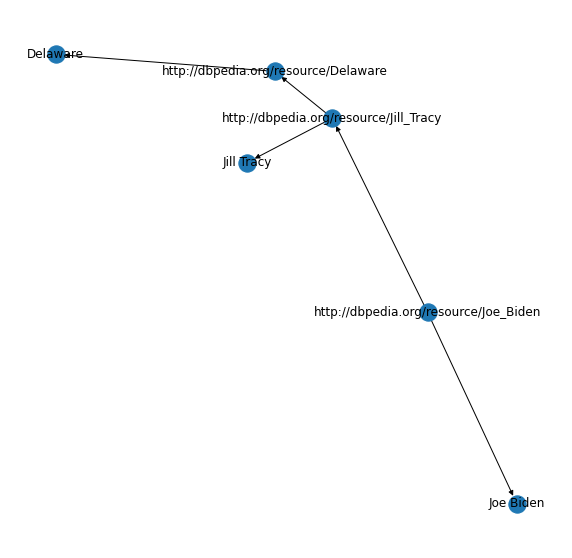

In [19]:
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx
import matplotlib.pyplot as plt

G = rdflib_to_networkx_multidigraph(g)

# Plot Networkx instance of RDF Graph
pos = nx.spring_layout(G, scale=2)
edge_labels = nx.get_edge_attributes(G, 'r')
plt.figure(figsize=(10,10))
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
nx.draw(G, with_labels=True)

#if not in interactive mode for 

plt.show()